<h1>Simulation of a PV system with pvlib - Example file</h1>

Based on the ENERPOS PV pant, Terre Sainte Campus, St-Pierre, La Reunion. 1 year of weather with GHI, DHI and DNI (BNI), air temperature and wind speed measurements. Modules and inverter parameters from manufacturer's data sheet. A single array connected to a single inverter. No extra losses.

---
<h2>Define PV modules, inverter and losses, create PV system and simulate</h2>

<h3>Import weather data</h3>

In [5]:
# Import weather data from file
import pandas as pd
import datetime
import pytz

df_weather = pd.read_csv('Meteo_Terre_Sainte_2022_10min.txt')

# Subset variables needed
df_weather = df_weather[['datetime', 'GHI', 'DHI', 'BNI','DBT', 'Ws10']]
df_weather.rename(columns={'GHI':'ghi', 'DHI':'dhi', 'BNI':'dni','DBT':'temp_air', 'Ws10':'wind_speed'},inplace=True)
# Time as index
df_weather['datetime'] = pd.to_datetime(df_weather.datetime)
df_weather['datetime'] = df_weather['datetime'].dt.tz_localize('Indian/Reunion')
df_weather.set_index('datetime', inplace=True)

# df_weather = df_weather[(df_weather.index >'2022-02-01 00:00:00') & (df_weather.index < '2022-02-07 00:00:00')]

# Let's see the head, shape and columns of the data
df_weather.head(10)
#print(df_weather.shape)

,ghi,dhi,dni,temp_air,wind_speed
datetime,,,,,
2022-01-01 00:10:00+04:00,0.0,0.0,0.0,21.912,0.1825
2022-01-01 00:20:00+04:00,0.0,0.0,0.0,22.291,0.8360
2022-01-01 00:30:00+04:00,0.0,0.0,0.0,22.614,0.9403
2022-01-01 00:40:00+04:00,0.0,0.0,0.0,22.756,0.5832
2022-01-01 00:50:00+04:00,0.0,0.0,0.0,22.889,0.5106
2022-01-01 01:00:00+04:00,0.0,0.0,0.0,22.903,0.2824
2022-01-01 01:10:00+04:00,0.0,0.0,0.0,22.860,0.1599
2022-01-01 01:20:00+04:00,0.0,0.0,0.0,22.768,0.1485
2022-01-01 01:30:00+04:00,0.0,0.0,0.0,22.573,0.1644


<h3>Define location, array slope and orientation</h3>

In [6]:
import pvlib
# Coordinates of the weather station
latitude = -21.333
longitude = 55.483
altitude = 75.0

# Define the location object
location = pvlib.location.Location(latitude, longitude, altitude=altitude)

# Define the PV system
surface_tilt = 9
surface_azimuth = 194

<h3>Define modules and inverter</h3>

In [7]:
# Create the module and inverter spec from data sheet
from pvlib import pvsystem

# Import module specs from custom CEC file
module_database = pvsystem.retrieve_sam(path = 'Custom-cec-modules.csv')
module = module_database.TENESOL_TE2000_200W
# Estimate the parameters for the CEC single diode model
""" WARNING - This function relies on NREL's SAM tool. So PySAM, its Python API, needs to be installed 
in the same computer. Otherwise, you can expect the following error: 'ImportError if NREL-PySAM is not installed.'
"""
module.I_L_ref, module.I_o_ref, module.R_s, module.R_sh_ref, module.a_ref, module.Adjust = pvlib.ivtools.sdm.fit_cec_sam(
    celltype = module.Technology,
    v_mp = module.V_mp_ref, 
    i_mp = module.I_mp_ref,
    v_oc = module.V_oc_ref, 
    i_sc = module.I_sc_ref, 
    alpha_sc = module.alpha_sc,
    beta_voc = module.beta_oc, 
    gamma_pmp = module.gamma_r,
    cells_in_series = module.N_s, 
    temp_ref = 25)
# Let's have a look to the module specs
print(module)

# Import inverter specs from custom CEC file
inverter_database = pvlib.pvsystem.retrieve_sam(path = 'Custom-cec-inverters.csv')
inverter = inverter_database.Delta_SI_3300
# Let's have a look to the inverter specs
print(inverter)

Technology       multiSi
Bifacial               0
STC               200.25
PTC                147.8
A_c             1.325126
Length              1.51
Width              0.995
N_s                   54
I_sc_ref             8.0
V_oc_ref            32.9
I_mp_ref             7.5
V_mp_ref            26.7
alpha_sc          0.0044
beta_oc          -0.1161
T_NOCT              45.0
a_ref           1.397766
I_L_ref          8.00658
I_o_ref              0.0
R_s              0.28049
R_sh_ref      341.003245
Adjust          6.650831
gamma_r            -0.46
BIPV                   N
Version           Custom
Date          01/03/2019
Name: TENESOL_TE2000_200W, dtype: object
Vac           240.000000
Paco         3485.000000
Pdco         3630.000000
Vdco          270.000000
Pso            30.000000
C0             -0.000014
C1             -0.000124
C2             -0.000878
C3             -0.002700
Pnt             0.000000
Vdcmax        540.000000
Idcmax         24.000000
Mppt_low      150.000000
Mppt_high

<h3>Create and simulate the PV plant</h3>

In [8]:
# Create the PV System
from pvlib.modelchain import ModelChain

# Define Temperature Paremeters 
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']

# Define the basics of the class PVSystem
system = pvlib.pvsystem.PVSystem(surface_tilt=surface_tilt,
                                 surface_azimuth=surface_azimuth, albedo=0.2,
                                 module=module, module_parameters=module,
                                 temperature_model_parameters=temperature_model_parameters,
                                 strings_per_inverter=2,
                                 modules_per_string=9,
                                 inverter=inverter,
                                 inverter_parameters=inverter,
                                 racking_model='open_rack')

# Creation of the ModelChain object
mc = pvlib.modelchain.ModelChain(system, location, 
                                 aoi_model='physical', 
                                 spectral_model='no_loss',
                                 name='AssessingSolar_PV')

# Have a look to the ModelChain
print(mc)

ModelChain: 
  name: AssessingSolar_PV
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses


In [9]:
# Pass the weather data to the model
""" 
The weather DataFrame must include the irradiance components with the names 'dni', 'ghi', and 'dhi'. 
The air temperature named 'temp_air' in degree Celsius and wind speed 'wind_speed' in m/s are optional.
"""
mc.run_model(df_weather)

ModelChain: 
  name: AssessingSolar_PV
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [10]:
mc.results.ac.to_csv('prod_AC_ENERPOS_South.csv')

---
<h2>Plot results</h2>

<Figure size 1600x900 with 0 Axes>

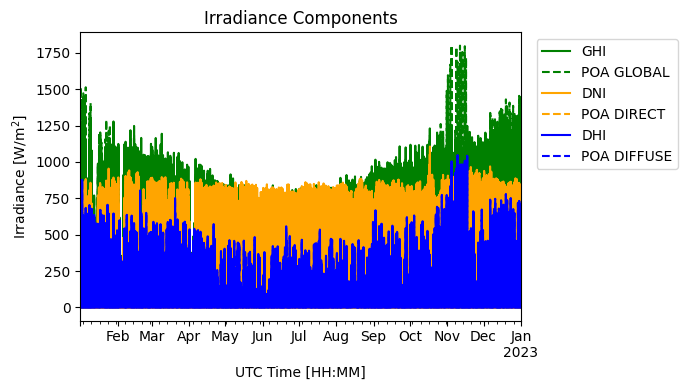

In [15]:
# Plot irradiance component

import matplotlib.pyplot as plt
#from matplotlib.dates import DateFormatter


# Define labels of variables to plot and colors 
irrad_labels = ['ghi', 'dni', 'dhi']
poa_labels = ['poa_global', 'poa_direct', 'poa_diffuse']
colors = ['green', 'orange', 'blue']

# Plot of Irradiance Variables
fig, ax = plt.subplots(figsize=(7, 4))

for i in range(len(irrad_labels)):
    mc.results.weather[irrad_labels[i]].plot(label=irrad_labels[i].upper(), color=colors[i])
    ax = mc.results.total_irrad[poa_labels[i]].plot(label=poa_labels[i].upper().replace('_', ' '), color=colors[i], ls='--')
#ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax.set_ylabel('Irradiance [W/m$^2$]')
ax.set_xlabel('UTC Time [HH:MM]')
ax.set_title('Irradiance Components')
plt.legend(bbox_to_anchor=(1.02,1))
plt.tight_layout()
plt.show() 

<Figure size 1600x900 with 0 Axes>

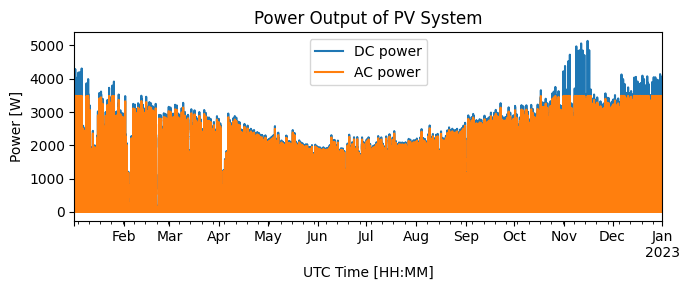

In [16]:
# Plot of Power Output 

fig, ax = plt.subplots(figsize=(7, 3))

mc.results.dc['p_mp'].plot(label='DC power')
ax = mc.results.ac.plot(label='AC power')
#ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax.set_ylabel('Power [W]')
ax.set_xlabel('UTC Time [HH:MM]')
ax.set_title('Power Output of PV System')
plt.legend()
plt.tight_layout()
plt.show() 